# Exporting a model

The goal of this notebook is to export a trained PyTorch model that can be used in a CoreML or iOS app.

Can also eventually have an export for TensorFlow Lite/Web Development.

See the guides here:
* Exporting a model with CoreML tools from PyTorch - https://coremltools.readme.io/docs/convert-a-torchvision-model-from-pytorch 
* Example export script from yolov5 -  https://github.com/ultralytics/yolov5/blob/master/export.py  

In [17]:
import numpy as np
np.__version__

'1.23.1'

In [18]:
import json
import torch
import torchvision
import wandb
import pandas as pd
import os

from pathlib import Path

# Set device
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../utils/google-storage-key.json"
GS_BUCKET = "gs://food_vision_bucket_with_object_versioning"

WANDB_PROJECT = "test_wandb_artifacts_by_reference"
WANDB_MODEL = "trained_model:latest" 
WANDB_DATASET = "food_vision_199_classes_images:latest"
WANDB_LABELS = "food_vision_labels:latest"
WANDB_RUN_TAGS = ["export"]
WANDB_JOB_TYPE = "export_trained_model_to_other_platforms"
PRETRAINED = True
PREDICTIONS_OUTPUT_DIR = "predictions"
MODEL = "coatnext_nano_rw_224"
INPUT_SIZE = 224

Using device: cuda


In [19]:
run = wandb.init(project=WANDB_PROJECT, 
                 job_type=WANDB_JOB_TYPE,
                 tags=WANDB_RUN_TAGS)

def load_artifact(artifact_name, artifact_type):
    artifact = run.use_artifact(artifact_name, type=artifact_type)
    artifact_dir = artifact.download()
    return artifact_dir

# ## Get images
# # TODO: change this artifact to just be a standard GCP bucket of all images (rather than food_vision_199_classes_images:latest) -> all images in a single bucket (not 199_classes, just all images), then index with labels
# images_dir = load_artifact(WANDB_DATASET, "dataset")

# print(f"[INFO] Images directory: {images_dir}")

## Get annotations
labels_dir = load_artifact(WANDB_LABELS, "labels")
print(f"[INFO] Labels directory: {labels_dir}")

labels_path = Path(labels_dir) / "annotations.csv"
print(f"[INFO] Labels path: {labels_path}")
annotations = pd.read_csv(labels_path)

# Create a dictionary of class_names and labels
class_names = annotations["class_name"].to_list()
class_labels = annotations["label"].to_list()
class_dict = dict(sorted(dict(zip(class_labels, class_names)).items()))

# Create a reverse mapped dictionary of class_dict
reverse_class_dict = dict(zip(class_dict.values(), class_dict.keys()))

print(f"[INFO] Working with: {len(class_dict)} classes")

[INFO] Labels directory: ./artifacts/food_vision_labels:v23
[INFO] Labels path: artifacts/food_vision_labels:v23/annotations.csv
[INFO] Working with: 204 classes


## Download and import the trained model

Want to get the model file from Weights & Biases.

In [20]:
# import sys
# !{sys.executable} -m pip install timm google-cloud-storage

In [21]:
# Append the upper path to sys
import sys
sys.path.append("..")
from data_loader import FoodVisionReader
from pathlib import Path

import timm
from timm.models import create_model
from timm.data import create_transform, ImageDataset

In [22]:
# Download model artifact
model_artifact = run.use_artifact(WANDB_MODEL, type="model")
model_at_dir = model_artifact.download()
print(f"[INFO] Model artifact directory: {model_at_dir}")

# Get list of all files with "*.pth" in model_at_dir
model_path = str(list(Path(model_at_dir).rglob("*.pth"))[0])
print(f"[INFO] Model path: {model_path}")

# Create the model with timm
model = timm.create_model(
    model_name=MODEL, pretrained=PRETRAINED, num_classes=len(class_dict)
)
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# Create the data transform
transform = create_transform(input_size=INPUT_SIZE, is_training=False)

wandb: Downloading large artifact trained_model:latest, 54.60MB. 1 files... Done. 0:0:0.0


[INFO] Model artifact directory: ./artifacts/trained_model:v38
[INFO] Model path: artifacts/trained_model:v38/2023-02-14_09-42-55_model_coatnext_nano_rw_224.pth


## Convert to Core ML 

* The default type in Core ML is now an ML Program - https://coremltools.readme.io/docs/ml-programs
* The following sections follow on from this guide - https://coremltools.readme.io/docs/convert-a-torchvision-model-from-pytorch 

In [23]:
# Put the model in eval() mode
model.eval()

# Trace the model with random data
example_input = torch.rand(1, 3, INPUT_SIZE, INPUT_SIZE)
traced_model = torch.jit.trace(model, example_input)
out = traced_model(example_input)

In [24]:
# Get the class names (Core ML wants them in a list)
class_names = list(class_dict.values())
assert len(class_names) == len(class_dict)
class_names[:5]

['almond_butter', 'almonds', 'apple_red', 'apricot', 'asparagus']

### Preprocess the image input for torchvision models 

In [25]:
# import sys
# !{sys.executable} -m pip install coremltools numpy==1.23.1

In [26]:
# import sys
# !{sys.executable} -m pip install matplotlib

In [27]:
import coremltools as ct

In [28]:
import numpy
numpy.__version__

'1.23.1'

In [29]:
# Set the image scale and bias and for input image processing
import coremltools as ct 

scale = 1/(0.226*255.0)
bias = [- 0.485/(0.229) , - 0.456/(0.224), - 0.406/(0.225)]

image_input = ct.ImageType(name="input_image",
                           shape=example_input.shape,
                           scale=scale,
                           bias=bias)

### Converting from PyTorch to a Neural Network (Core ML neural network)

In [30]:
# Use image_input in the inputs parameter
# Convert to Core ML using the Unified Conversion API
coreml_model = ct.convert(
    model=traced_model,
    inputs=[image_input],
    outputs=[ct.TensorType(name="output")],
    classifier_config=ct.ClassifierConfig(class_names),
)

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 963/963 [00:01<00:00, 917.84 ops/s] 


In [31]:
# Get the current date in YYYY-MM-DD format
from datetime import date
today = date.today()
today = today.strftime("%Y-%m-%d")

# Save the Core ML model to file
core_ml_model_save_path = f"{today}_food_vision_{len(class_names)}_classes.mlmodel"
print("[INFO] Saving Core ML model to:", core_ml_model_save_path)
coreml_model.save(core_ml_model_save_path)

[INFO] Saving Core ML model to: 2023-02-14_food_vision_204_classes.mlmodel


## TODO: Make predictions with the CoreML model and evaluate them against the PyTorch model (to make sure the model works)

* Could make 1000 random predictions on the test dataset to make sure they line up with each other... 

annotations.head()

In [57]:
# Get list of all images in ..images/sample-food-images
images_dir = Path("../../images/sample-food-images")
images = list(images_dir.glob("*"))
images[:5]

[PosixPath('../../images/sample-food-images/IMG_1646.png'),
 PosixPath('../../images/sample-food-images/IMG_1652.png'),
 PosixPath('../../images/sample-food-images/hamburger.jpeg'),
 PosixPath('../../images/sample-food-images/IMG_1653.png'),
 PosixPath('../../images/sample-food-images/IMG_1647.png')]

/var/folders/c4/qj4gdk190td18bqvjjh0p3p00000gn/T/ipykernel_42014/4270294942.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


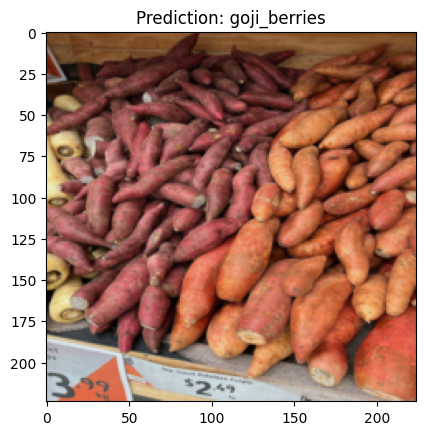

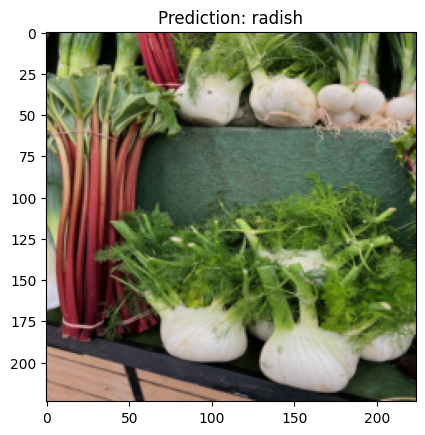

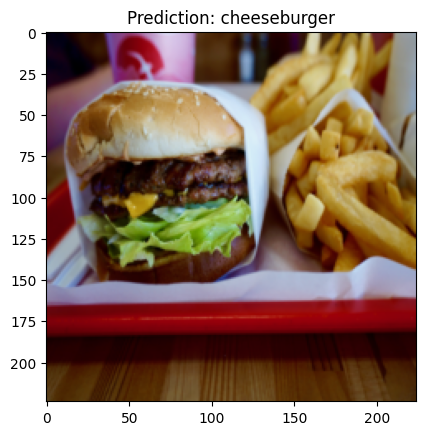

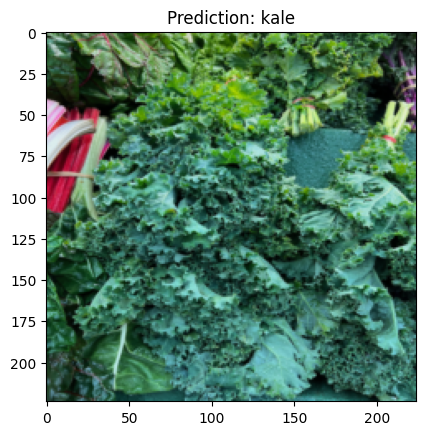

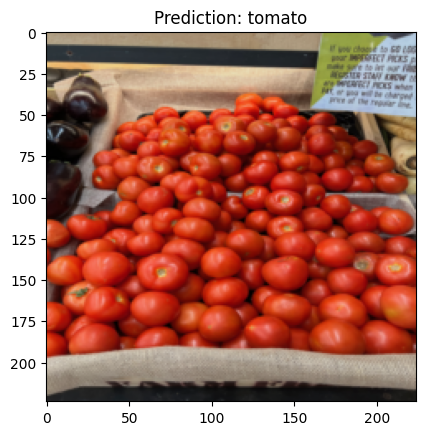

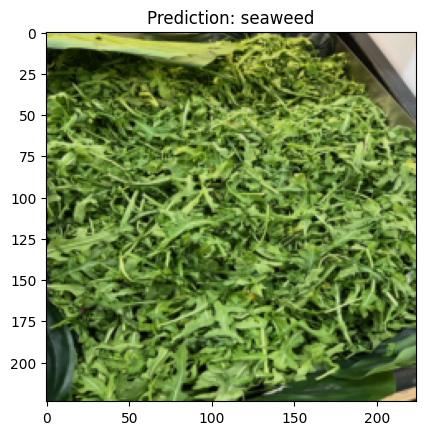

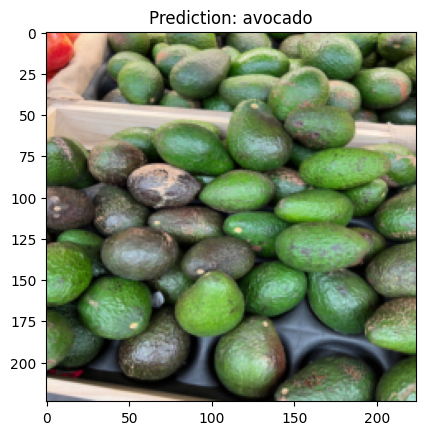

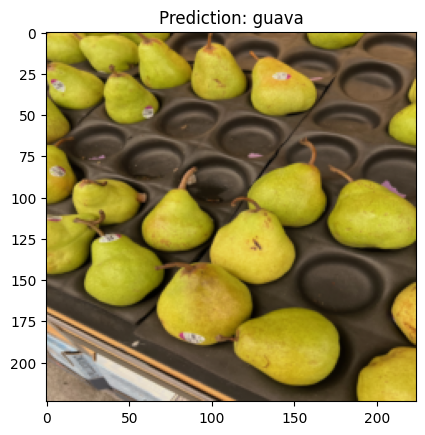

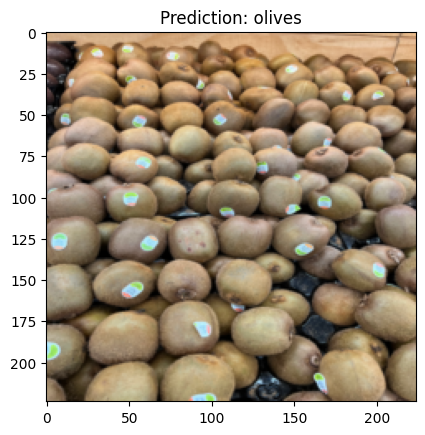

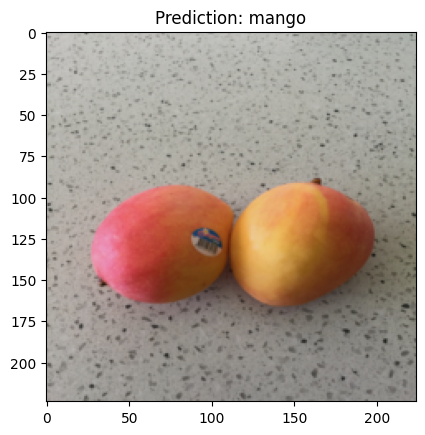

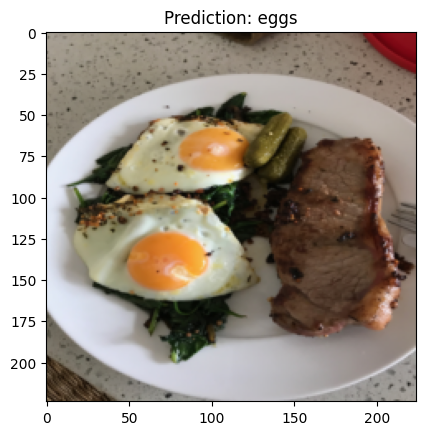

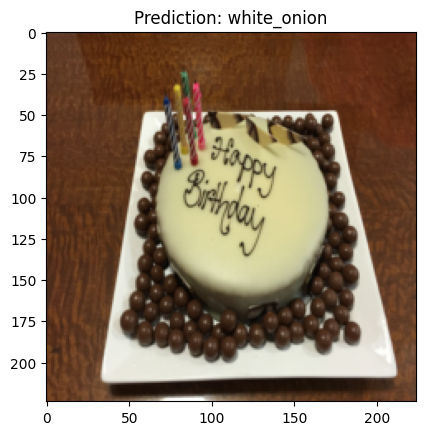

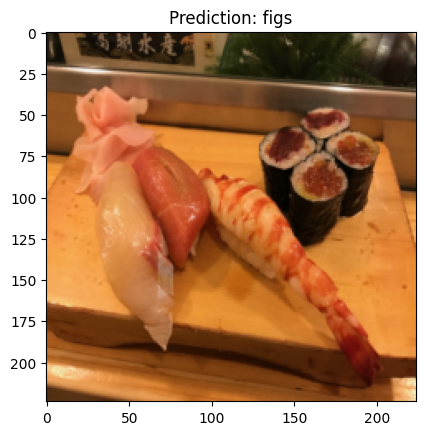

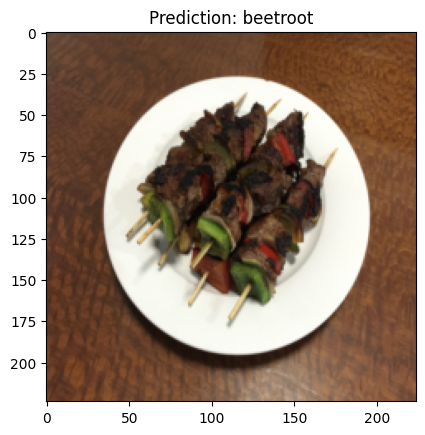

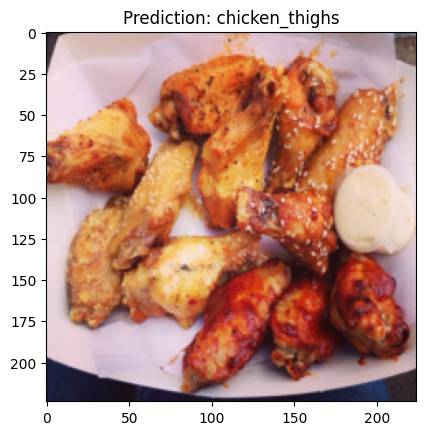

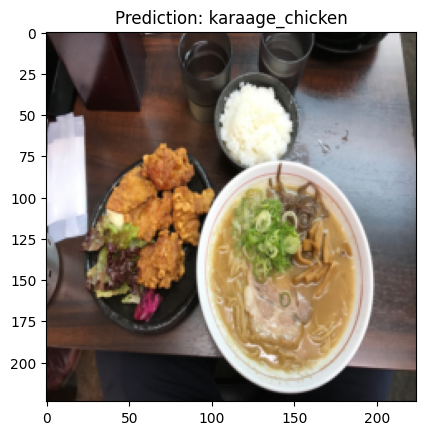

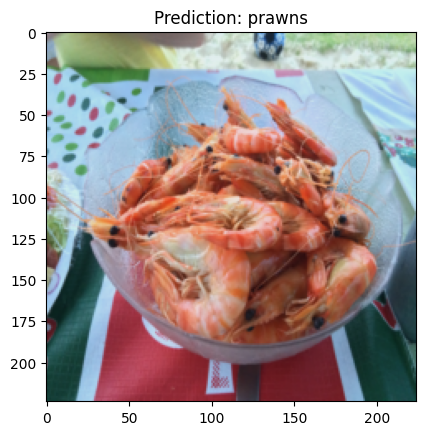

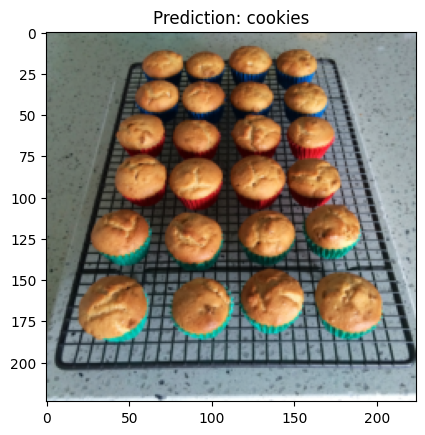

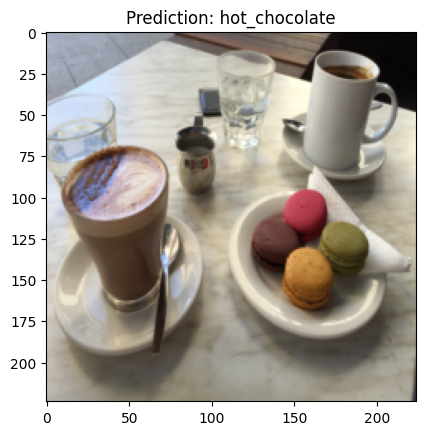

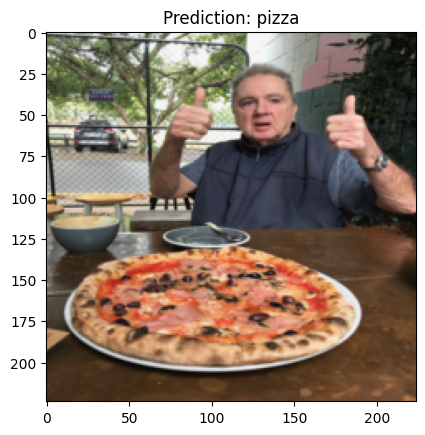

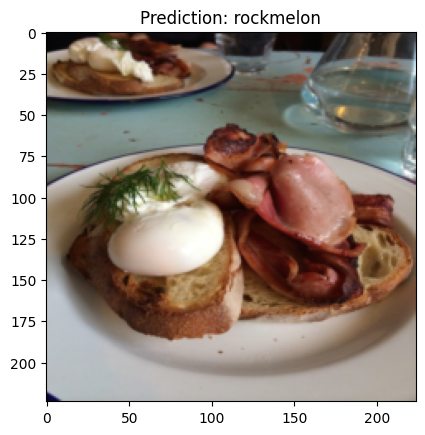

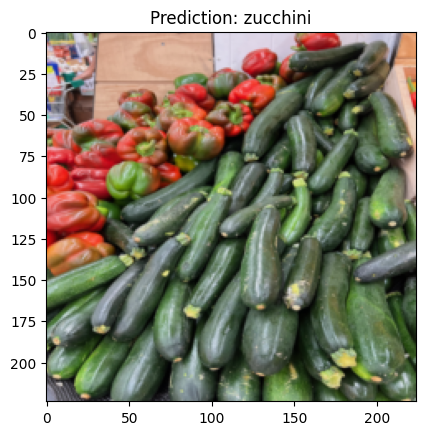

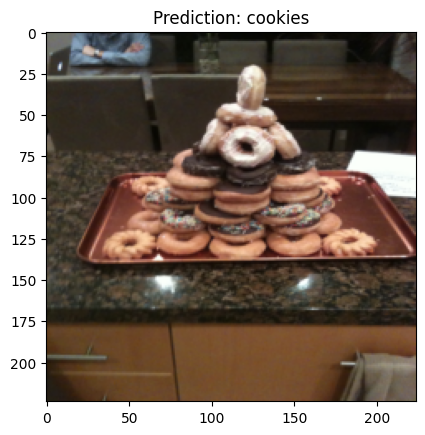

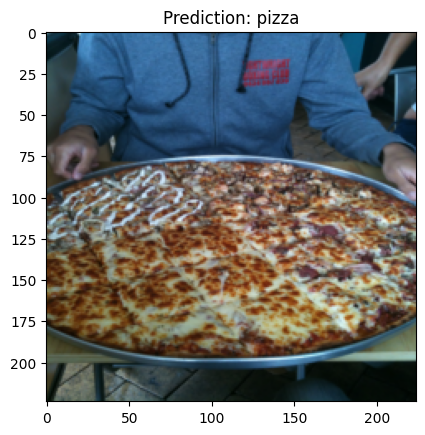

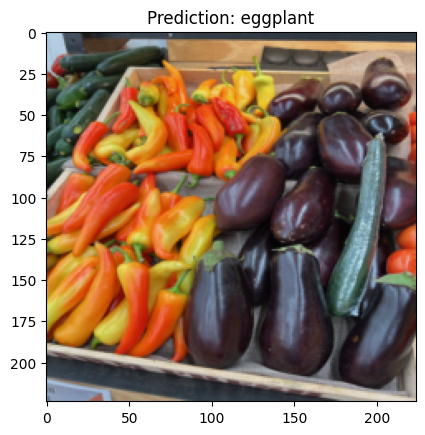

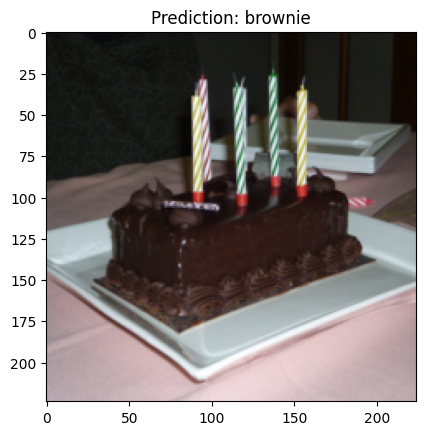

In [59]:
import PIL
# Choose a random image
import random

import matplotlib.pyplot as plt

# plt.figure()
for image in images:
    img_path = str(image)
    img = PIL.Image.open(img_path).convert("RGB")
    img = img.resize([INPUT_SIZE, INPUT_SIZE], resample=PIL.Image.Resampling.BILINEAR)

    # Make a prediction with the CoreML model
    coreml_out_dict = coreml_model.predict({"image_input": img}) # only possible directly on macOS
    # print(f"coreml top-1 prediction: {coreml_out_dict['classLabel']}")
    # print("top class label: ", coreml_out_dict["classLabel"])
    
    # Plot the image with matplotlib
    plt.figure()
    plt.imshow(img)
    plt.title(f"Prediction: {coreml_out_dict['classLabel']}")
    

### Get the protobuf spec

In [60]:
# Get the protobuf spec of the model
spec = coreml_model.get_spec()
for out in spec.description.output:
    if out.type.WhichOneof("Type") == "dictionaryType":
        coreml_dict_name = out.name
        break

### Make a Core ML Prediction

Model prediction directly with Core ML (and `coremltools`) is only possible directly on MacOS 10.13 or later. 

In [61]:
coreml_dict_name

'output'

In [62]:
# Make a prediction with the Core ML version of the model  
coreml_out_dict = coreml_model.predict({"image_input": img}) # only possible directly on macOS
print("coreml predictions:")
print("top class label: ", coreml_out_dict["classLabel"])
coreml_out_dict

coreml predictions:
top class label:  brownie


{'classLabel': 'brownie',
 'output': {'cream': -0.81591796875,
  'capsicum': -0.10968017578125,
  'orange': 1.5673828125,
  'white_onion': -0.201171875,
  'chimichurri': -1.1279296875,
  'brownie': 4.546875,
  'rockmelon': 0.4033203125,
  'lemon': 0.333251953125,
  'starfruit': 3.9140625,
  'chocolate_cake': 4.04296875,
  'popcorn': -1.443359375,
  'salad': -1.412109375,
  'beans': -1.126953125,
  'strawberries': -2.41796875,
  'zucchini': 1.3408203125,
  'cabbage': 0.205322265625,
  'dates': -0.03424072265625,
  'pork_loins': -2.21875,
  'pumpkin': -2.42578125,
  'ice_cream': -0.640625,
  'sausage_roll': 0.34814453125,
  'leek': 1.87109375,
  'omelette': -1.234375,
  'raspberries': -1.2568359375,
  'ginger': -1.0810546875,
  'tea': 2.4296875,
  'scrambled_eggs': -1.119140625,
  'milk': 1.0087890625,
  'corn': -1.0009765625,
  'cheeseburger': -0.061248779296875,
  'barbecue_sauce': -1.787109375,
  'sardines': -0.177978515625,
  'salami': -0.486083984375,
  'cherries': 3.740234375,
  'g

In [63]:
coreml_prob_dict = coreml_out_dict[coreml_dict_name]

values_vector = np.array(list(coreml_prob_dict.values()))
keys_vector = list(coreml_prob_dict.keys())
top_3_indices_coreml = np.argsort(-values_vector)[:3]
for i in range(3):
    idx = top_3_indices_coreml[i]
    score_value = values_vector[idx]
    class_id = keys_vector[idx]
    print("class name: {}, raw score value: {}".format(class_id, score_value))

class name: brownie, raw score value: 4.546875
class name: celery, raw score value: 4.12890625
class name: chocolate_cake, raw score value: 4.04296875


In [81]:
torch.softmax(torch.tensor(list(coreml_out_dict[coreml_dict_name].values())), dim=0)

tensor(0.1236)

In [91]:
dict_values = torch.tensor(list(coreml_out_dict[coreml_dict_name].values()))

# Normalize the dict_values
dict_values = dict_values / torch.sum(dict_values)

# Perform softmax on the dict_values
# dict_values = torch.softmax(dict_values, dim=0)

dict_values

tensor([ 1.9653e-02,  2.6418e-03, -3.7753e-02,  4.8455e-03,  2.7168e-02,
        -1.0952e-01, -9.7146e-03, -8.0269e-03, -9.4276e-02, -9.7381e-02,
         3.4765e-02,  3.4013e-02,  2.7144e-02,  5.8240e-02, -3.2296e-02,
        -4.9455e-03,  8.2474e-04,  5.3442e-02,  5.8429e-02,  1.5430e-02,
        -8.3856e-03, -4.5068e-02,  2.9732e-02,  3.0273e-02,  2.6039e-02,
        -5.8523e-02,  2.6956e-02, -2.4298e-02,  2.4110e-02,  1.4753e-03,
         4.3045e-02,  4.2869e-03,  1.1708e-02, -9.0089e-02,  3.1731e-02,
         4.5774e-02,  8.7384e-03, -2.4051e-03, -4.2410e-02,  1.0126e-02,
         7.5129e-02,  4.3280e-02,  5.5865e-05,  1.9241e-02, -1.0832e-02,
        -1.1959e-03, -1.2490e-02,  3.4648e-02,  2.0923e-02,  8.9795e-03,
         4.7044e-02,  8.1668e-02, -1.7359e-02, -7.2118e-02, -6.6567e-03,
        -5.9087e-02,  3.9799e-02,  2.9708e-02,  5.8429e-02, -3.8600e-02,
        -4.5350e-02,  4.9255e-02,  4.0781e-03, -1.7959e-02,  6.7555e-02,
        -4.5139e-02, -1.6477e-02,  2.3816e-02,  2.9